In [160]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [161]:
def create_hamiltonian(qubits, g, show_steps=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if show_steps: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        H += -temp.to_matrix()
        if show_steps: print("-"+str(temp)+" ", end='')
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        H += -g*temp.to_matrix()
        if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
    if show_steps: print("\n")
    
    if show_steps:
        eigenvalues = np.linalg.eigvals(H)
        print("Original eigenvalues:", eigenvalues)
    
    # scale eigenvalues of the Hamiltonian
    scale_factor = (3/4) *pi
    H = scale_factor*H / np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite (not nessary in this usecase)
    # H += pi*np.eye(2**qubits)

    if show_steps:
        eigenvalues = np.linalg.eigvals(H)
        print("Scaled eigenvalues of the hamiltonian:\n", np.linalg.eigvals(H))
        min_eigenvalue = np.min(eigenvalues)
        print("Lowest energy eigenvalue", min_eigenvalue); print()

    return H

def hadamard_test(ham, t, W = 'Re', g=0, shots=100):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    counts = aer_sim.run(trans_qc, shots = shots).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas

def create_hadamard_test(ham, t, backend, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    trans_qc = transpile(qc, backend)
    return trans_qc

def calculate_re(counts, shots):
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas



In [162]:
'''
ham: system hamiltonian
Dt: time step
K: maximum number of iterations
backend: system to transpile circuits for
'''
def generate_s_k(ham, Dt, K, g=0, shots=100):
    s_k = []
    for i in range(K):
        s_k.append(hadamard_test(ham, i*Dt, g=g, shots = shots))
    return s_k

'''
ham: system hamiltonian
Dt: time step
K: maximum number of iterations
backend: system to transpile circuits for
'''
def transpile_s_k(ham, Dt, K, backend, g=0):
    trans_qcs = []
    for i in range(K):
        trans_qcs.append(create_hadamard_test(ham, i*Dt, backend, g=g))
    return trans_qcs


'''
start: where to start reading the data from
k: number of columns
d: how much data per column
s_k: quantum data to create matrix
'''
def make_X(start, k, d, s_k):
    X = np.zeros((d, k))
    for i in range(len(X)):
        for j in range(len(X[i])):
            # print(i+j+start)
            X[i][j] = s_k[(i+j+start)%len(s_k)]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = np.linalg.svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    for l in range(len(sigma)):
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the singular value
            U[:,l] = 0   # remove the corresponding column
            V[l,:] = 0   # remove the corresponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    return U @ sigma_mat @ V

def check_convergence(data, order = 2):
    if len(data) <= order: return False
    temp = data
    for _ in range(order):
        if abs(temp[-1]-temp[-2]) > 0.001:
            return False
        # print(temp)
        temp2 = []
        for i in range(len(temp)-1):
            temp2.append(temp[i+1]-temp[i])
        temp = temp2
    return abs(temp[0]) <= 0.001

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each iteration
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(s_k, Dt, noise_threshold, alpha = 1/2, est_E_0s = [], show_steps = False): 
    K = int(2*pi/Dt) # maximum iterations
    if show_steps: print("Max iterations:", K)
    if show_steps: print("s_k:", s_k)
    k = -1
    while (True):
        k=k+1
        if show_steps: print("k =", k)
        d = math.floor(alpha*(k))
        if d < 1 or k < 1: continue
        if k*Dt > 2*pi: break
        X = make_X(0, k, d, s_k)
        if show_steps: print("X\n",X)
        Xprime = make_X(1, k, d, s_k)
        if show_steps: print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        if show_steps: print("X_sigma\n",X_sigma)
        A = Xprime @ np.linalg.pinv(X_sigma)
        if show_steps: print("A\n",A)  
        eigenvalues,_ = np.linalg.eig(A)
        if show_steps: print("eigenvalues\n", eigenvalues)
        eigenmax = max(eigenvalues, key=abs)
        if show_steps: print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        if show_steps: print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        if show_steps: print("E_0 =", E_0)
        if check_convergence(est_E_0s, order = 10): break
    return E_0

In [163]:
# SYSTEM PARAMETERS
particles          = 2
g                  = 4 # magnetic field strength
time_steps         = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1] # time steps to test use with ODMD
Ks                 = [2*int(2*pi/time_step)+1 for time_step in time_steps]
noise_threshold    = 0.01
shots              = 100

# computation_type OPTIONS: Simulation, Hardware
computation_type   = 'S'

# data_source OPTIONS: Generation (Only useable with Simulation), Files, Job (Only Usable with Hardware)
data_source        = 'F'


In [164]:
# parameter checking (if theres an error change system parameters)
assert(computation_type[0].upper() == 'S' or computation_type[0].upper() == 'H')
assert(data_source[0].upper() == 'G' or data_source[0].upper() == 'F' or data_source[0].upper() == 'J')
assert(not (computation_type[0].upper() == 'S' and data_source[0].upper() == 'J'))
assert(not (computation_type[0].upper() == 'H' and data_source[0].upper() == 'G'))

# backend setup
if computation_type[0].upper() == 'H' or data_source[0].upper() == 'J':
    api_token = input("Enter API Token:")
    from qiskit_ibm_runtime import QiskitRuntimeService as QRS
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
else:
    backend = AerSimulator()
sampler = Sampler(backend)

In [165]:
Ham = create_hamiltonian(particles, g)
s_ks = {}

# save data when using files
if data_source[0].upper() == 'F':
    from qiskit import qpy
    import os

    def empty(filename):
        try:
            return os.path.getsize(filename) == 0
        except FileNotFoundError:
            return True
        
    for i in range(len(time_steps)):
        time_step = time_steps[i]
        K = Ks[i]
        filename = "Transpiled_Circuits/sys="+computation_type[0].upper()+"_n="+str(particles)+"_g="+str(g)+"_Dt="+str(time_step)+".qpy"
        if empty(filename):
            print("Creating file for Dt =", time_step)
            trans_qcs = transpile_s_k(Ham, time_step, K, backend, g=g)
            with open(filename, "wb") as file:
                qpy.dump(trans_qcs, file)
        else:
            print("File found for Dt =", time_step)
    print()

# load/generate s_k data
if data_source[0].upper() == 'F':
    print("Loading data from files")
    trans_qcs = []
    for time_step in time_steps:
        filename = "Transpiled_Circuits/sys="+computation_type[0].upper()+"_n="+str(particles)+"_g="+str(g)+"_Dt="+str(time_step)+".qpy"
        with open(filename, 'rb') as file:
            qcs = qpy.load(file)
            trans_qcs.append(qcs)
    
    trans_qcs = sum(trans_qcs, []) # flatten list
    if computation_type[0].upper() == 'H': print("Sending Job")
    results = sampler.run(trans_qcs, shots = shots).result() # all time steps are put into a single job
    if computation_type[0].upper() == 'H': print("Recieved Data")
    print()
elif data_source[0].upper() == 'J':
    job_id = input("Enter Job ID:")
    job = service.job(job_id)
    print("Loading data from job")
    results = job.result()
    print()


# construct s_k
for i in range(len(time_steps)):
    time_step = time_steps[i]
    if data_source[0].upper() == 'G':
        print("Generating Data for Dt =", time_step)
        K = Ks[i]
        s_ks[time_step] = generate_s_k(Ham, time_step, K, shots = shots)
    else:
        print("Calculating s_k for time step:", time_step)
        start = sum(Ks[0:i])
        result = results[start:start+Ks[i]] # seperate the data needed for this iteration
        s_k = []
        for i in range(len(result)):
            raw_data = result[i].data
            cbit = list(raw_data.keys())[0]
            s_k.append(calculate_re(raw_data[cbit].get_counts(), shots))
        s_ks[time_step] = s_k



File found for Dt = 0.1
File found for Dt = 0.2
File found for Dt = 0.3
File found for Dt = 0.4
File found for Dt = 0.5
File found for Dt = 0.6
File found for Dt = 0.7
File found for Dt = 0.8
File found for Dt = 0.9
File found for Dt = 1

Loading data from files

Calculating s_k for time step: 0.1
Calculating s_k for time step: 0.2
Calculating s_k for time step: 0.3
Calculating s_k for time step: 0.4
Calculating s_k for time step: 0.5
Calculating s_k for time step: 0.6
Calculating s_k for time step: 0.7
Calculating s_k for time step: 0.8
Calculating s_k for time step: 0.9
Calculating s_k for time step: 1


In [166]:
trials = []
results = []
for time_step in time_steps:
    print("Using data from time step:", time_step)
    est_E_0s = []
    result = ODMD(s_ks[time_step], time_step, noise_threshold, est_E_0s = est_E_0s)
    print("Calculated Energy:", result)
    results.append(result)
    trials.append(est_E_0s)


Using data from time step: 0.1
Calculated Energy: -2.3593785428635297
Using data from time step: 0.2
Calculated Energy: -0.0
Using data from time step: 0.3
Calculated Energy: -2.3108954179614027
Using data from time step: 0.4
Calculated Energy: -7.853981633974483
Using data from time step: 0.5
Calculated Energy: -2.326572247954973
Using data from time step: 0.6
Calculated Energy: -2.329455730943335
Using data from time step: 0.7
Calculated Energy: -2.320317834600426
Using data from time step: 0.8
Calculated Energy: -2.333597251183752
Using data from time step: 0.9
Calculated Energy: -2.35950457130568
Using data from time step: 1
Calculated Energy: -2.333513548632313


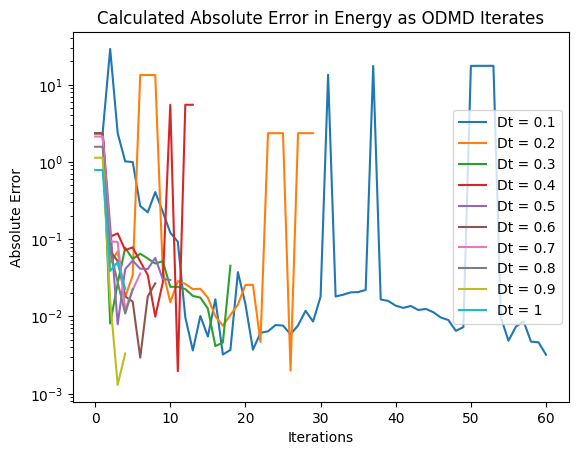

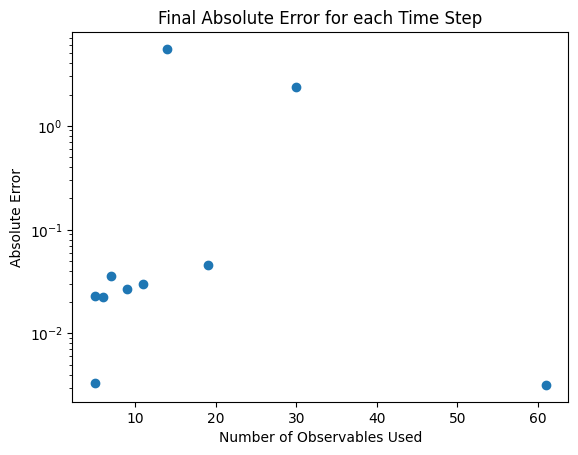

[-2.3593785428635297, -0.0, -2.3108954179614027, -7.853981633974483, -2.326572247954973, -2.329455730943335, -2.320317834600426, -2.333597251183752, -2.35950457130568, -2.333513548632313]


In [167]:
real_E_0 = -abs(np.linalg.eigvals(Ham)[0].real)
for i in range(len(trials)):
    err = [abs(w-real_E_0) for w in trials[i]]
    # plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], err, label = 'Dt = '+str(time_steps[i]))
    plt.plot(err, label = 'Dt = '+str(time_steps[i]))
plt.title("Calculated Absolute Error in Energy as ODMD Iterates")
plt.ylabel("Absolute Error")
plt.xlabel("Iterations")
plt.legend()
# plt.ylim([0,.5])
plt.yscale('log')
plt.savefig("Graphs/"+computation_type[0].upper()+"_Absolute_Error_in_Energy.png")
plt.show()

plt.title("Final Absolute Error for each Time Step")
plt.xlabel("Number of Observables Used")
plt.ylabel("Absolute Error")
plt.yscale('log')
observables = [len(w) for w in trials]
plt.scatter(observables, [abs(real_E_0-i) for i in results])
# plt.ylim([-abs(np.linalg.eigvals(Ham)[0].real)+.5,-abs(np.linalg.eigvals(Ham)[0].real)-.5])
plt.savefig("Graphs/"+computation_type[0].upper()+"_Final_Absolute_Error_Time_Step.png")
plt.show()
print(results)


In [7]:
from TFIM_generator import generate_TFIM_gates 
from qiskit import QuantumCircuit

qubits = 10
gates = generate_TFIM_gates(qubits, 10, 2, .01, '../f3cpp')
qc = QuantumCircuit(qubits+1)
for i in gates:
    qc.append(i, range(qubits+1))
print(qc)

workedx
********************
***  TFYZ MODEL  ***
********************

  N = 10: timesteps = 10 , dt = 2

    hx = const value: 0.01
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 0.01, Jz = 1
* timestep 2: hx = 0.01, Jz = 1
* timestep 3: hx = 0.01, Jz = 1
* timestep 4: hx = 0.01, Jz = 1
* timestep 5: hx = 0.01, Jz = 1
* timestep 6: hx = 0.01, Jz = 1
    - merge layer1
    - merge layer2
* timestep 7: hx = 0.01, Jz = 1
    - merge layer1
    - merge layer2
* timestep 8: hx = 0.01, Jz = 1
    - merge layer1
    - merge layer2
* timestep 9: hx = 0.01, Jz = 1
    - merge layer1
    - merge layer2
* timestep 10: hx = 0.01, Jz = 1
    - merge layer1
    - merge layer2

                                                                        »
 q_0: ─────■──────────■──────────■──────────■──────────■──────────■─────»
      ┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
 q_1: ┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
      │  